In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00


In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.2 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import openai
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

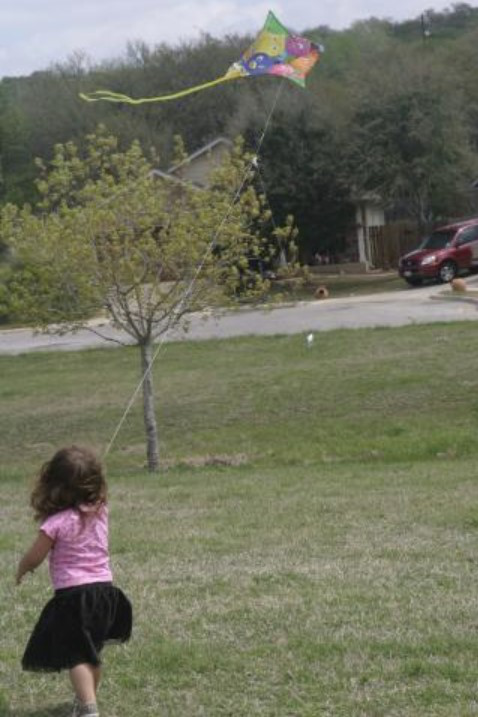

In [ ]:
image = Image.open("201766590"+'.jpg')
display(image)

In [ ]:
question = 'Is the girl flying the kite in the top of the picture?'

# Generate Caption by BLIP2

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
model.to(DEVICE);

For stability purposes, it is recommended to have accelerate installed when using this model in torch.float16, please install it with `pip install accelerate`


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

# Ask ChatGPT to give 5 relational questions

In [ ]:
title_to_gpt = "Here are some information of an image:\n"
caption_to_gpt = caption
task_to_gpt = "\nYour task is to answer question: "
question_to_gpt = question
format_to_gpt = "\nList five relational questions to help you answer the given question.\nRelational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':"
prompt_to_gpt = title_to_gpt + caption_to_gpt + task_to_gpt + question_to_gpt + format_to_gpt

completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt}
  ]
)

print(completion.choices[0].message)

{
  "content": "1. What is the location of the girl in the picture?\n2. What is the distance between the girl and the kite?\n3. What is the angle of the kite string in relation to the ground?\n4. How high in the sky is the kite flying?\n5. Is there any other object in the picture that is higher than the girl's kite?",
  "role": "assistant"
}


In [ ]:
print(prompt_to_gpt)

Here are some information of an image:
a little girl flying a kite in a field
Your task is to answer question: Is the girl flying the kite in the top of the picture?
List five relational questions to help you answer the given question.
Relational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':


In [ ]:
print(completion.choices[0].message.content)

1. What is the location of the girl in the picture?
2. What is the distance between the girl and the kite?
3. What is the angle of the kite string in relation to the ground?
4. How high in the sky is the kite flying?
5. Is there any other object in the picture that is higher than the girl's kite?


# Let MDETR answer those questions

In [ ]:
answers_from_mdetr = ['lawn', 'yes', 'sky', 'huge', 'no']

In [ ]:
question_to_gpt2 = ""
question_list = completion.choices[0].message.content.split('\n')
for i in range(len(question_list)):
  question_to_gpt2 += question_list[i] + '  ' + answers_from_mdetr[i] + '\n'

print(question_to_gpt2)

['1. What is the location of the girl in the picture?', '2. What is the distance between the girl and the kite?', '3. What is the angle of the kite string in relation to the ground?', '4. How high in the sky is the kite flying?', "5. Is there any other object in the picture that is higher than the girl's kite?"]
1. What is the location of the girl in the picture?  lawn
2. What is the distance between the girl and the kite?  yes
3. What is the angle of the kite string in relation to the ground?  sky
4. How high in the sky is the kite flying?  huge
5. Is there any other object in the picture that is higher than the girl's kite?  no



# Let ChatGPT decide the final answer

In [ ]:
information_to_gpt = "\nYou have the following information: \n"
prompt_to_gpt2 = title_to_gpt + caption_to_gpt + task_to_gpt + question_to_gpt + information_to_gpt + question_to_gpt2 + '\nPlease answer with one word.'
print(prompt_to_gpt2)

Here are some information of an image:
a little girl flying a kite in a field
Your task is to answer question: Is the girl flying the kite in the top of the picture?
You have the following information: 
1. What is the location of the girl in the picture?  lawn
2. What is the distance between the girl and the kite?  yes
3. What is the angle of the kite string in relation to the ground?  sky
4. How high in the sky is the kite flying?  huge
5. Is there any other object in the picture that is higher than the girl's kite?  no

Please answer with one word.


In [ ]:
completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt2}
  ]
)

print(completion.choices[0].message.content)

No.


In [ ]:
information_to_gpt = "\nYou have the following information: \n"
prompt_to_gpt2 = title_to_gpt + caption_to_gpt + task_to_gpt + question_to_gpt + information_to_gpt + question_to_gpt2
print(prompt_to_gpt2)

Here are some information of an image:
a little girl flying a kite in a field
Your task is to answer question: Is the girl flying the kite in the top of the picture?
You have the following information: 
1. What is the location of the girl in the picture?  lawn
2. What is the distance between the girl and the kite?  yes
3. What is the angle of the kite string in relation to the ground?  sky
4. How high in the sky is the kite flying?  huge
5. Is there any other object in the picture that is higher than the girl's kite?  no



In [ ]:
completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt2}
  ]
)

print(completion.choices[0].message.content)

Based on the information given, it is not possible to determine whether the girl is flying the kite in the top of the picture or not.
